In [38]:
#import library
import torch
import torch.nn as nn
import os
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

In [39]:
# # Helper function to denormalize images
# def denormalize_image(image, mean, std):
#     for i in range(3):  # For each channel (RGB)
#         image[i] = image[i] * std[i] + mean[i]
#     return image

In [40]:
#Define test dataset transformations (same as train and validation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # VGG16 expects 224x224 input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # VGG16 normalization
])

In [41]:
# Load the test dataset
test_folder = datasets.ImageFolder(root= r"C:\Users\user\Documents\!TA\!TA\cornealtopography\Independent Test Set", transform=test_transform)
test_data_dirs = ['Keratoconus', 'Normal', 'Suspect']  # Subdirectories to load images from

# test_dataset = datasets.ImageFolder(test_folder, transform=test_transform)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [42]:
test_loader = DataLoader(test_folder, batch_size=64, shuffle=False)

In [43]:
# # Create paths for each subfolder
# test_dataset_paths = []
# for subdir in test_data_dirs:
#     subfolder_path = os.path.join(test_folder, subdir)
#     for case_folder in os.listdir(subfolder_path):  # List the case folders
#         case_folder_path = os.path.join(subfolder_path, case_folder)
#         if os.path.isdir(case_folder_path):  # Ensure it's a directory
#             test_dataset_paths.append(case_folder_path)

# # combine the directories into one test set
# test_loader = torch.utils.data.DataLoader(
#     datasets.ImageFolder(root=test_dataset_paths[0], transform=test_transform),
#     batch_size=32, shuffle=False
# )

In [44]:
# Check dataset size
print(f"Testing dataset contains {len(test_folder)} images.")

Testing dataset contains 1050 images.


In [45]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [46]:
# Load the model architecture
#vgg16 = models.vgg16(weights=None)  # No weights loaded at this point
vgg11 = models.vgg11(weights=None).to(device)  # No weights loaded at this point

In [47]:
vgg11.classifier = nn.Sequential(
    nn.Linear(in_features=512 * 7 * 7, out_features=4096),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=4096, out_features=4096),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=4096, out_features=3)
).to(device)

In [48]:
vgg11.load_state_dict(torch.load("best_vgg11_with_dropout_model.pth", map_location=device))
vgg11.eval()

C:\Users\user\AppData\Local\Temp\ipykernel_15108\1167690859.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg11.load_state_dict(torch.load("best_vgg11_with_dropout_mod

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [49]:
# Evaluate the model
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vgg11(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [50]:
# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_folder.classes))

Classification Report:
              precision    recall  f1-score   support

 Keratoconus       0.96      0.64      0.77       350
      Normal       0.55      0.07      0.12       350
     Suspect       0.42      0.93      0.58       350

    accuracy                           0.54      1050
   macro avg       0.64      0.54      0.49      1050
weighted avg       0.64      0.54      0.49      1050



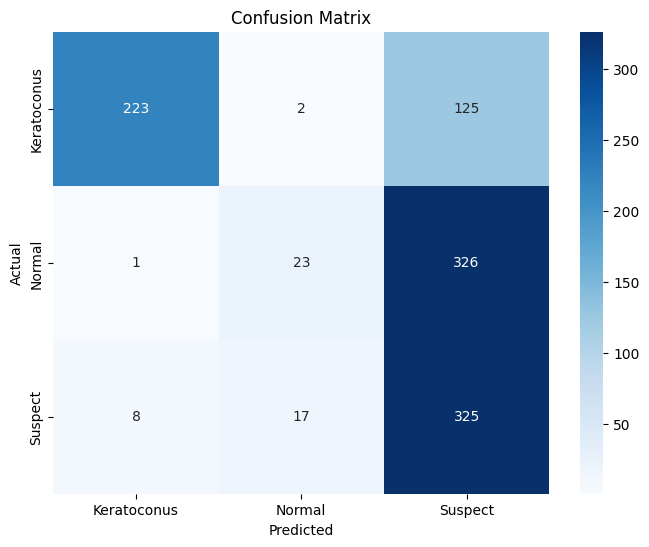

In [51]:
# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=test_folder.classes, yticklabels=test_folder.classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()